# Schrieffer-Wolff ZZ plot

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import constants
import scipy
from pysqkit.drives.pulse_shapes import gaussian_top
from typing import List, Dict, Callable
from scipy.optimize import minimize
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import copy
import json

from IPython.display import display, Latex

In [4]:
with open('sw_data/jc.txt') as file_jc:
    jc = json.load(file_jc)
with open('sw_data/zz.txt') as file_zz:
    zz = json.load(file_zz)
with open('sw_data/transm_freq.txt') as file_freq:
    transm_freq = json.load(file_freq)
with open('sw_data/zz_sw.txt') as file_zz_sw:
    zz_sw = json.load(file_zz_sw)
with open('sw_data/mu_yz.txt') as file_cr_sw:
    mu_yz = json.load(file_cr_sw)
with open('sw_data/mu_yi.txt') as file_cr_sw:
    mu_yi = json.load(file_cr_sw)
with open('sw_data/mu_yz_sw.txt') as file_cr_sw:
    mu_yz_sw = json.load(file_cr_sw)
with open('sw_data/mu_yi_sw.txt') as file_cr_sw:
    mu_yi_sw = json.load(file_cr_sw)
with open('data_cr_transmon_fluxonium/data_cr_transmon_fluxonium_linear.txt') as file_res:
    result_sw_lin = json.load(file_res)


In [5]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    eps: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*eps*pulse, times)
    return np.abs(integral - np.pi/2)  #Watch out factor of 2?  

In [6]:
gate_time = []
gate_time_sw = []
t_rise = 5.0 # [ns]
eps_drive = 0.6 #GHz

t_tot_0 = [100.0]

for mu, mu_sw in zip(mu_yz, mu_yz_sw):
    args_to_pass = (t_rise, np.abs(mu)*eps_drive)
    args_to_pass_sw = (t_rise, np.abs(mu_sw)*eps_drive)

# We find the total time to obtain the desired gate

    minimization_result = minimize(func_to_minimize, t_tot_0, args=args_to_pass)

    gate_time.append(minimization_result['x'][0]) 
    
    minimization_result_sw = minimize(func_to_minimize, t_tot_0, args=args_to_pass_sw)

    gate_time_sw.append(minimization_result_sw['x'][0]) 

KeyboardInterrupt: 

In [ ]:
def plot_zz(
    jc: dict,
    transm_freq,
    zz,
    zz_sw,
    plot_setup={'fs': 20, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16, 'fsl':18},
    save=False,
    dark=False
):
    if dark:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')
        
    matplotlib.rcParams['mathtext.fontset'] = 'cm'
    fig, ax = plt.subplots(figsize=(8, 8))
    colors_dict = {"0": 'yellow', '1': 'red', '2':'blue'}
    for key in jc.keys():       
        ax.semilogy(transm_freq, np.array(zz[key])*1e3, linewidth=plot_setup["lw"], 
                    color=colors_dict[key], label='$J_C/ 2 \\pi = {}  \, \\mathrm{{MHz}}$'.format(jc[key]*1e3))
        ax.semilogy(transm_freq, np.array(zz_sw[key])*1e3, linewidth=plot_setup["lw"], 
                    color=colors_dict[key], linestyle='--')
    ax.set_xlabel('$\\omega_T/2 \\pi \, (\\mathrm{MHz})$', fontsize=plot_setup["fs"])
    x_ticks = [4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8]
    x_ticks_latex = ['$4.2$', '$4.4$', '$4.6$', '$4.8$', '$5.0$', '$5.2$', '$5.4$', '$5.6$', '$5.8$']
    plt.xticks(x_ticks, x_ticks_latex)
    y_ticks = [0.1, 0.01]
    y_ticks_latex = ['$10^{-1}$', '$10^{-2}$']
    plt.yticks(y_ticks, y_ticks_latex)
    ax.set_ylabel('$\\xi_{ZZ}/2 \\pi \, (\\mathrm{MHz})$', fontsize=plot_setup['fs'])
    ax.tick_params(axis='both', labelsize=plot_setup["ls"])
    plt.legend(loc='best', fontsize=plot_setup["fsl"], bbox_to_anchor=(0.72,0.5))
    if save:
        plt.savefig("zz_fig.svg")
    plt.show()

In [ ]:
plot_zz(jc, transm_freq, zz, zz_sw, save=False, dark=False)

In [10]:
def plot_cr(
    transm_freq,
    mu_yz,
    mu_yz_sw,
    mu_yi,
    mu_yi_sw,
    plot_setup={'fs': 20, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16, 'fsl':18},
    save=False
):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors_dict = {"0": 'black', '1': 'red', '2':'blue'}      
    ax.plot(transm_freq, mu_yz, linewidth=plot_setup["lw"], 
            color='blue', label='$\mu_{YZ}$')
    ax.plot(transm_freq, mu_yz_sw, linewidth=plot_setup["lw"], 
            color='blue', linestyle='--')
    ax.plot(transm_freq, mu_yi, linewidth=plot_setup["lw"], 
            color='red', label='$\mu_{YI}$')
    ax.plot(transm_freq, mu_yi_sw, linewidth=plot_setup["lw"], 
            color='red', linestyle='--')
    ax.set_xlabel('$\\omega_T/2 \\pi \, (\\mathrm{MHz})$', fontsize=plot_setup["fs"])
    x_ticks = [4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8]
    x_ticks_latex = ['$4.2$', '$4.4$', '$4.6$', '$4.8$', '$5.0$', '$5.2$', '$5.4$', '$5.6$', '$5.8$']
    y_ticks = [-0.003, -0.002, -0.001, 0.000, 0.001, 0.002]
    y_ticks_latex = ['$-3 \\times 10^{-3}$', '$-2 \\times 10^{-3}$', '$-1 \\times 10^{-3}$', 
                    '$0 $', '$1 \\times 10^{-3}$', '$2 \\times 10^{-3}$']
    plt.xticks(x_ticks, x_ticks_latex)
    plt.yticks(y_ticks, y_ticks_latex)
    ax.tick_params(axis='both', labelsize=plot_setup["ls"])
    plt.legend(loc='best', fontsize=plot_setup["fsl"])
    if save:
        plt.savefig("cr_fig.svg")
    plt.show()

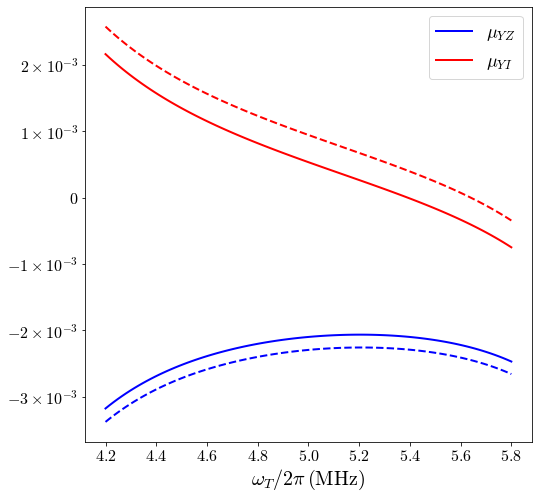

In [12]:
plot_cr(transm_freq, mu_yz, mu_yz_sw, mu_yi, mu_yi_sw, save=True)

In [36]:
def plot_cr_gate_time(
    transm_freq,
    gate_time,
    gate_time_sw,
    plot_setup={'fs': 20, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16, 'fsl':18},
    save=False,
    dark=False
):
    if dark:
        plt.style.use('dark_background')
        line_color = 'white'
    else:
        line_color = 'black'
        plt.style.use('default')
        
    matplotlib.rcParams['mathtext.fontset'] = 'cm'
    fig, ax = plt.subplots(figsize=(8, 8))   
    ax.plot(transm_freq, gate_time, linewidth=plot_setup["lw"], label='Exact', color=line_color)
    ax.plot(transm_freq, gate_time_sw, linewidth=plot_setup["lw"], linestyle='--', label='SW', color=line_color)
    ax.set_xlabel('$\\omega_T/2 \\pi \, (\\mathrm{MHz})$', fontsize=plot_setup["fs"])
    ax.set_ylabel('$t_{\mathrm{gate}} \, (\\mathrm{ns})$', fontsize=plot_setup["fs"])
    x_ticks = [4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8]
    x_ticks_latex = ['$4.2$', '$4.4$', '$4.6$', '$4.8$', '$5.0$', '$5.2$', '$5.4$', '$5.6$', '$5.8$']
    y_ticks = [130 + 10*x for x in range(0, 9)]
    y_ticks_latex = ["$" + str(y) + "$" for y in y_ticks]
    plt.xticks(x_ticks, x_ticks_latex)
    plt.yticks(y_ticks, y_ticks_latex)
    ax.tick_params(axis='both', labelsize=plot_setup["ls"])
    plt.legend(loc='best', fontsize=plot_setup["fsl"])
    if save:
        plt.savefig("cr_gate_time_fig.svg")
    plt.show()

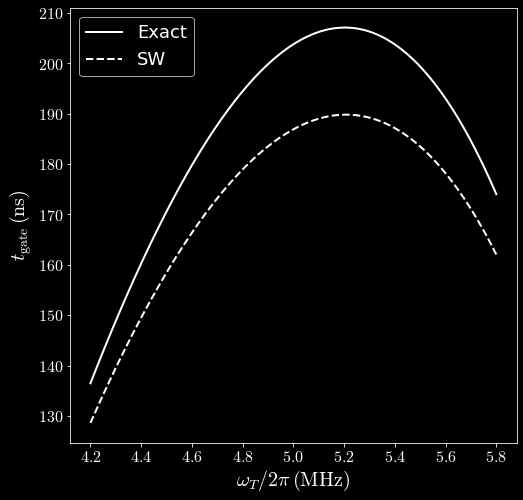

In [38]:
plot_cr_gate_time(transm_freq, gate_time, gate_time_sw, save=True, dark=True)